# MNIST Classification

The goal of this notebook is to implement a model consisting of just a softmax layer for classifying MNIST images, hence to perform a multiclass classification task. The notation follows the convention introduced for PW02:

<code>m</code>: Number of samples <br>
<code>n</code>: Number of features

Please follow the instructions in the cells below to conduct the following tasks:

1. Implement the functions to prepare the data (very similar to PW02).
2. Implement softmax, the cross entropy cost for multiclass and its gradient.
3. Implement the `optimize` function (with given function signature) by using the classes `Metrics` and `MiniBatches`.  
4. Run several trainings with different hyper-parameter settings and determine your favorite setting (1b).
5. Compute the Error Rates for the individual Digits (1c)
6. Analyze misclassified images with worst score (1d)
8. Plot the weights as images (1e)
7. Analyze different weights initialisation strategies (1f)

### Loading and Preparing the Data

Some preparatory steps to be applied before training:
* Imports: numpy and matplotlib
* Loading the data (same as for PW of previous week) 
* Some plot utilities
* Splitting the dataset into train and test
* Data Standarisation

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
### START YOUR CODE ### 
data_home = './data/'
### END YOUR CODE ### 

#### Load Data

In [3]:
from sklearn.datasets import fetch_openml

def load_mnist(data_home):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images.     
    Parameters: 
    data_home -- Absolute path to the DATA_HOME  
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (1,m) where m is the number of images
    shape -- (28,28)
    """
    mnist = fetch_openml(name='mnist_784', version=1, cache=True, data_home=data_home)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)


#### Plotting Utility

In [4]:
def plot_img(img, label, shape):
    """
    Plot the x array by reshaping it into a square array of given shape
    and print the label.
    
    Parameters:
    img -- array with the intensities to be plotted of shape (shape[0]*shape[1])
    label -- label 
    shape -- 2d tuple with the dimensions of the image to be plotted.
    """
    plt.imshow(np.reshape(img, shape), cmap=plt.cm.gray)
    plt.title("Label %i"%label)


def plot_digits(x,y,selection,shape, cols=5):
    """
    Plots the digits in a mosaic with given number of columns.

    Arguments:
    x -- array of images of size (n,m)
    y -- array of labels of size (1,m)
    selection -- list of selection of samples to be plotted
    shape -- shape of the images (a 2d tuple)
    selected_digits -- tuple with the two selected digits (the first associated with label 1, the second with label 0)
    """
    if len(selection)==0:
        print("No images in the selection!")
        return
    cols = min(cols, len(selection))
    rows = len(selection)/cols+1
    plt.figure(figsize=(20,4*rows))
    for index, (image, label) in enumerate(zip(x.T[selection,:], y.T[selection,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, shape), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (selection[index],label), fontsize = 12)
    plt.tight_layout()

#### Split Data and reshape as specified

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' with 20\% test data.

Furthermore, we reshape input data x to (n,m).

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test(x, y, test_size=0.20):
    """
    Split the dataset consisting of an array of images (shape (n, m)) and an array of labels (shape (1, m))
    into train and test set.
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (1, m) where m is the number of samples
    test_size -- fraction of samples to reserve as test sample
    
    Returns:
    x_train -- np.ndarray of images of shape (n,m1) used for training
    y_train -- np.ndarray of labels of shape (1,m1) used for training
    x_test -- np.ndarray of images of shape (n,m2) used for testing
    y_test -- np.ndarray of labels of shape (1,m2) used for testing
    """
    # split 
    # train_test_split() expects x, y in shapes (m, *), (m, *) 
    
    out = train_test_split(x.T, y.T, test_size=0.20, random_state=1)
    
    # transpose back the output obtained from the train_test_split-function
    x_train, x_test, y_train, y_test = (x.T for x in out)
    
    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test

#### Data Normalisation

Normalize the data - apply min/max normalization.


In [6]:
def normalize(x_train, x_test):
    """
    Normalizes pixel values using min-max normalization, min and max are calculated globally over all features n
    

    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    ### START YOUR CODE ###  
    maxx = x_train.max()
    minn = x_train.min()
    
    x_train = 2 * (x_train - minn) / (maxx - minn) - 1
    x_test = 2 * (x_test - minn) / (maxx - minn) - 1
    ### END YOUR CODE ###     

    return x_train, x_test

#### Test normalization

In [7]:
x_train_unittest = np.array([[10, 5], [-5, -10]])
x_test_unittest = np.array([[10, 1], [0, -10]])
actual_train, actual_test = normalize(x_train_unittest, x_test_unittest)
expected_train, expected_test = np.array([[1, 0.5], [-0.5, -1]]), np.array([[1, 0.1], [0, -1]])
np.testing.assert_almost_equal(expected_train, actual_train)
np.testing.assert_almost_equal(expected_test, actual_test)

### Softmax

Implement the softmax function - actually, the softmax layer with given weights-matrix $W$ and bias-vector $b$. 

In [8]:
def predict(W, b, X):
    '''
    Compute the per class probabilities for all the m samples by using a softmax layer with parameters (W, b).
    
    Arguments:
    W -- weights, a numpy array with shape (ny, nx) (with ny=10 for MNIST).
    b -- biases, a numpy array with shape (ny,1)
    X -- input data of size (nx,m)
    
    Returns:
    A -- a numpy array of shape (ny,m) with the prediction probabilities for the digits.
    ''' 
    ### START YOUR CODE ###
    z = W.dot(X) + b
    shiftz = z - np.max(z)
    exps = np.exp(shiftz)
    softmax = exps/np.sum(exps, axis=0)
    return softmax
    ### END YOUR CODE ###

#### TEST Softmax

In [9]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([2, 3]).reshape(2,1)
A = predict(W,b,X)
Aexp = np.array([0.01587624,0.86681333,0.11731043]).reshape(A.shape)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), 1.0, decimal=8)

X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)
Aexp = np.array([[0.46831053, 0.01321289, 0.21194156, 0.01321289],
 [0.46831053, 0.26538793, 0.57611688, 0.26538793],
 [0.06337894, 0.72139918, 0.21194156, 0.72139918]]
)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), np.ones(4,dtype='float'), decimal=8)

### Cost Function (Cross Entropy)

Implement the cross entropy cost function for the multi-class setting. 

For later use implement a function to create one-hot vectors.

In [10]:
def cost(Ypred, Y, eps=1.0e-12):
    """
    Computes the cross entropy cost function for given predicted values (Ypred) and labels (Y).
    
    Parameters:
    Ypred -- prediction from softmax, a numpy array of shape (ny,m)
    Y -- ground truth labels, a numpy array with shape (1,m) containing digits 0,1,...,9. 
    
    Returns:
    Cross Entropy Cost
    """
    ### START YOUR CODE ###
    Ypred = np.clip(Ypred, eps, 1-eps)
    Y = onehot(Y, Ypred.shape[0])
    cost = -np.sum(Y * np.log(Ypred), axis=0).mean()
    return cost
    ### END YOUR CODE ###

In [11]:
def onehot(y,n):
    """
    Constructs a one-hot-vector from a given array of labels (shape (1,m), containing numbers 0,1,...,n-1) 
    and the number of classes n.
    The resulting array has shape (n,m) and in row j and column i a '1' if the i-th sample has label 'j'. 
    
    Parameters:
    y -- labels, numpy array of shape (1,m) 
    n -- number of labels

    Returns:
    On-hot-encoded vector of shape (n,m)
    """
    
    ### START YOUR CODE ###
    y = y.reshape(-1)
    result = np.eye(n)[y].T
    ### START YOUR CODE ###
    return result

#### TEST Cross Entropy Cost 

In [12]:
Y = np.array([1])
Ypred = np.array([0.04742587,0.95257413]).reshape(2,1)
J = cost(Ypred,Y)
Jexp = 0.04858735
np.testing.assert_almost_equal(J,Jexp,decimal=8)

Y = np.array([1,1,1,0])
Ypred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]])
Jexp = 0.01859102
J = cost(Ypred,Y)
np.testing.assert_almost_equal(J,Jexp,decimal=8)

In [13]:
## Test one-hot vector implementation ##
Y = np.array([1,3,0]).reshape(1,3)
onehot_comp = onehot(Y,4)
onehot_exp = np.array([[0,0,1],[1,0,0],[0,0,0],[0,1,0]]).reshape(4,3)
np.testing.assert_almost_equal(onehot_exp,onehot_comp,decimal=8)

### Update Rules for the Parameters

Implement the (estimate of) gradient of the cost function (cross entropy implemented above) with respect to the parameters of the softmax layer.
The contributions from the different samples given in $X$ and $Y$ should be averaged.

In [14]:
def gradient(X, Y, A):
    """
    Computes the components of the gradient w.r.t. weights and bias - by using the cross entropy cost. 
    
    Arguments:
    X -- input data of size (nx,m)
    Y -- output labels - a numpy array with shape (1,m).
    A -- predicted scores (as output of softmax) - a numpy array with shape (ny,m) 
    
    Returns:
    gradJ -- dictionary with the gradient w.r.t. W (key "dW" with shape (ny,nx)) and w.r.t. b (key "db" with shape (ny,1))
    """
    ### START YOUR CODE ### 
    Y = onehot(Y, A.shape[0])
    d = -(Y - A)
    
    m = A.shape[1]
    
    dw = 1/m * d.dot(X.T)
    db = 1/m * d.sum(axis=1).reshape(-1, 1)
    
    return {"dW": dw, "db": db}
    ### END YOUR CODE ###
    

#### Test the Calculation of the Gradient

In [15]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)

Y = np.array([1,1,1,1]).reshape(1,4)

gradJ = gradient(X,Y,A)
dW = gradJ['dW']
db = gradJ['db']
dWexp = np.array([[ 0.28053421,0.17666947],
                  [-0.00450948,-0.60619918],
                  [-0.27602473,0.42952972]]).reshape(3,2)
dbexp = np.array([0.17666947,-0.60619918,0.42952972]).reshape(3,1)
np.testing.assert_array_almost_equal(dW,dWexp,decimal=8)
np.testing.assert_array_almost_equal(db,dbexp, decimal=8)

### Metrics for measuring the performance of the algorithm

As metrics we compute the error rate as number of wrong predictions divided by the number of samples. 

In [16]:
def error_rate(Ypred, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    Ypred -- Predicted label, a numpy array of size (1,m)
    Y -- ground truth labels, a numpy array with shape (1,m)

    Returns:
    error_rate 
    """
    Ypredargmax = np.argmax(Ypred, axis=0)
    return np.mean(Y != Ypredargmax)

### Optimize (Learn)

As in PW02, we first provide the metrics class that is used for tracking progress during the training (by collecting suitable quantities).

In [17]:
class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost, smooth=False):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost -- cost function to use (a python function)
        smooth -- if set to true updates learning curve after each training step and also provides learning curves 
        smoothed over the epoch  
        """
        self.epochs = []
        self.smooth = smooth
        self.train_costs_last = []
        self.test_costs_last = []
        self.train_errors_last = []
        self.test_errors_last = []
        self.stepsize_w_last = []
        self.stepsize_b_last = []
        if self.smooth:
            self.train_costs_smoothed = []
            self.test_costs_smoothed = []
            self.train_errors_smoothed = []
            self.test_errors_smoothed = []
            self.stepsize_w_smoothed = []
            self.stepsize_b_smoothed = []

        self.cost_function = cost
        self.init_epoch()

            
    def init_epoch(self):
        self.train_costs_epoch = []
        self.test_costs_epoch = []
        self.train_errors_epoch = []
        self.test_errors_epoch = []
        self.stepsize_w_epoch = []
        self.stepsize_b_epoch = []
        
        
    def update_epoch(self, epoch):
        """
        Computes the average of the metrics over the epoch and adds the result to the per epoch history
        
        Parameters:
        epoch -- the epoch to add to the per epoch cache
        """
        self.epochs.append(epoch)
        if self.smooth:
            self.train_costs_smoothed.append(np.mean(self.train_costs_epoch))
            self.test_costs_smoothed.append(np.mean(self.test_costs_epoch))
            self.train_errors_smoothed.append(np.mean(self.train_errors_epoch))
            self.test_errors_smoothed.append(np.mean(self.test_errors_epoch))
            self.stepsize_w_smoothed.append(np.mean(self.stepsize_w_epoch))
            self.stepsize_b_smoothed.append(np.mean(self.stepsize_b_epoch))                    

        self.train_costs_last.append(self.train_costs_epoch[-1])
        self.test_costs_last.append(self.test_costs_epoch[-1])
        self.train_errors_last.append(self.train_errors_epoch[-1])
        self.test_errors_last.append(self.test_errors_epoch[-1])
        self.stepsize_w_last.append(self.stepsize_w_epoch[-1])
        self.stepsize_b_last.append(self.stepsize_b_epoch[-1])                    
        
        self.init_epoch()
    
        
    def update_iteration(self, ypred_train, y_train, ypred_test, y_test, dw, db):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_test -- predicted values on the test samples, a numpy array of shape (1,m2)
        y_test -- ground truth labels associated with the test samples, a numpy array of shape (1,m2)
        dw -- some lenght measure for the gradient w.r.t. the weights, a numpy array of shape (1,n)
        db -- gradient w.r.t. the bias, a scalar
        """
        Jtrain = self.cost_function(ypred_train, y_train)
        Jtest = self.cost_function(ypred_test, y_test)
        train_error = error_rate(ypred_train, y_train)
        test_error = error_rate(ypred_test, y_test)

        self.train_costs_epoch.append(Jtrain)
        self.test_costs_epoch.append(Jtest)
        self.train_errors_epoch.append(train_error)
        self.test_errors_epoch.append(test_error)
        self.stepsize_w_epoch.append(dw)
        self.stepsize_b_epoch.append(db)
        
        
    def print_latest_errors(self):
        print ("Train/test error after epoch %i: %f, %f" %(self.epochs[-1], self.train_errors_last[-1], self.test_errors_last[-1]))

    def print_latest_costs(self):
        print ("Train/test cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs_last[-1], self.test_costs_last[-1]))

    def plot_cost_curves(self, ymin=None, ymax=None, smooth=True, logy=True, show=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_costs_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_costs_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        else:
            plt.plot(self.epochs, self.train_costs_last, "b-", label="train")
            plt.plot(self.epochs, self.test_costs_last, "r-", label="test")   
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_costs_last)),max(1e-5,np.min(self.test_costs_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_costs_last),np.max(self.test_costs_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        if show:            
            plt.show()
    
    def plot_error_curves(self, ymin=None, ymax=None, smooth=True, logy=True, show=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_errors_last, "b-", label="train")
            plt.semilogy(self.epochs, self.test_errors_last, "r-", label="test")
            if self.smooth:
                plt.semilogy(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.semilogy(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        else: 
            plt.plot(self.epochs, self.train_errors_last, "b-", label="train")
            plt.plot(self.epochs, self.test_errors_last, "r-", label="test")
            minvalue = 0.0
            if self.smooth:
                plt.plot(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
                plt.plot(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_errors_last)),max(1e-5,np.min(self.test_errors_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_errors_last),np.max(self.test_errors_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        if show:            
            plt.show()

    def plot_stepsize_curves(self, ymin=None, ymax=None, smooth=True, show=True):
        plt.semilogy(self.epochs, self.stepsize_w_last, label="dw")
        plt.semilogy(self.epochs, self.stepsize_b_last, label="db")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.stepsize_w_smoothed, label="dw--")
            plt.semilogy(self.epochs, self.stepsize_b_smoothed, label="db--")
        plt.ylabel('Step Sizes (dw,db)')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.stepsize_w_last)),max(1e-5,np.min(self.stepsize_b_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.stepsize_w_last),np.max(self.stepsize_b_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        if show:            
            plt.show()    


In addition, we provide a utility class that allows to create mini-batches from the given dataset $(X,Y)$ with given batch size and initially shuffled. 

In [18]:
class MiniBatches():
    """
    Is initialized (constructed) with features x of shape (nx,m) and the labels y of shape (1,m).
    Is reshuffled at construction time.
    
    Then, a next minibatch (MBX,MBY) with MBX of shape (nx,batchsize) and MBY of shape (1,batchsize) is provided by calling next() on the object. 
    """    
    def __init__(self, x, y, batchsize):
        self.x = x
        self.y = y
        m = x.shape[1]
        if not batchsize:
            self.batchsize = m
        else:
            self.batchsize = batchsize
        self.n = x.shape[0]
        self.mb = int(m/batchsize)
        self.indices = np.arange(m)
        np.random.shuffle(self.indices)
        self.ib = 0
        
    def number_of_batches(self):
        return self.mb
        
    def next(self):
        it = self.indices[self.ib*self.batchsize:(self.ib+1)*self.batchsize]
        xbatch = self.x[:,it].reshape(self.n,self.batchsize)
        ybatch = self.y[:,it].reshape(1,self.batchsize)
        self.ib += 1
        return xbatch, ybatch


#### Optimisation

This function should implement the training loop - adopting mini-batch gradient descent with arbitrary batch size. Implement the given function signature. 

In [19]:
from tqdm import tqdm

def optimize(W, b, x_train, y_train, x_test, y_test, nepochs, alpha, batchsize=32, debug=False):
    """
    This function optimizes W and b by running (mini-batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    It returns the trained parameters as dictionary (keys "W" and "b") and various quantities 
    collected during learning in form of a Metrics object. The data (x_train, etc.) is assumed to contain 
    m1 training and m2 test samples.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    x_train -- input data for training of shape (nx,m1)
    y_train -- ground-truth labels - a numpy array with shape (1,m1)
    x_test -- input data for training of shape (nx,m2)
    y_test -- ground-truth labels - a numpy array with shape (1,m2)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    batchsize -- batch size, defaults to 32
    debug -- if true prints training and test error values after each epoch. Defaults to True.
    
    Returns:
    params -- dictionary containing the (final) weights w and bias b
    metrics -- contain the information about the learning curves
    """ 
    metrics = Metrics(cost = cost)

    m = x_train.shape[1] # number of samples
    nx = x_train.shape[0] # number of input features
    mb = int(m/batchsize) # number of mini-batches
    print("Optimisation with batchsize %i and %i number of batches per epoch."%(batchsize,mb))
    
    # compute and set the initial values for the metrics curves
    ypred_train = predict(W,b,x_train)    
    ypred_test = predict(W,b,x_test)    
    metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, 0, 0)
    metrics.update_epoch(0)
    
    # Loop over the epochs    
    for i in range(nepochs):
                
        # prepare shuffled mini-batches for this epoch
        batches = MiniBatches(x_train, y_train, batchsize)
        
        ### START YOUR CODE ###   
        
        for j in range(mb):
            xbatch, ybatch = batches.next()
            
            ypred_batch = predict(W,b,xbatch)

            grad = gradient(xbatch, ybatch, ypred_batch)

            W -= alpha * grad["dW"]
            b -= alpha * grad["db"]

        ypred_train = predict(W,b,x_train)    
        ypred_test = predict(W,b,x_test)
        grad = gradient(x_train, y_train, ypred_train)
        metrics.update_iteration(ypred_train, y_train, ypred_test, y_test,
                                 np.linalg.norm(grad["dW"]), np.linalg.norm(grad["db"]))

        ### END YOUR CODE ### 
            
        metrics.update_epoch(i+1)
            
        if debug:
            metrics.print_latest_errors()
        
    metrics.print_latest_costs()
    metrics.print_latest_errors()

    return {"W": W, "b": b}, metrics    

#### Initialize Parameters

Implement a utility to generate intialized parameters. 

As part of exercise 1f (below), different strategies should be considered. In a first round (exercise 1b and following) just use the first setting below (with weights and bias equals 0).

1. All weights and biases set to zero: $b=0, W=0$
2. Biases set to zero, weights generated as independent standard normal random numbers (mean zero, standard deviation 1)
3. Biases set to zero, weights generated as independent normal random numbers with mean zero and standard deviation properly scaled (divided by $\sqrt{n}$)

In [20]:
def initialize_params(nx, ny, method="zero"):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1)
    """
    ### START YOUR CODE ### 
    b = np.zeros((ny, 1))
    
    if method == "standard_normal":
        w = np.random.normal(loc=0, scale=1, size=(ny, nx))
    elif method == "scaled_normal":
        w = np.random.normal(loc=0, scale=1/np.sqrt(nx), size=(ny, nx))
    else:        
        w = np.zeros((ny, nx))
    ### END YOUR CODE ### 
    
    return w, b

#### Load and Prepare Data

In [21]:
x,y, shape = load_mnist(data_home)
x_train1, x_test1, y_train, y_test = prepare_train_test(x, y, test_size=0.20)
x_train, x_test = normalize(x_train1,x_test1)

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)
Shape training set:  (784, 56000) (1, 56000)
Shape test set:      (784, 14000) (1, 14000)


#### Run the Training for Specific Setting and Plot Learning Curves

Run the training of the model with a first setting (e.g. alpha=0.2, nepochs=20, batchsize=64).

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.363887, 0.470811
Train/test error after epoch 20: 0.081946, 0.095000


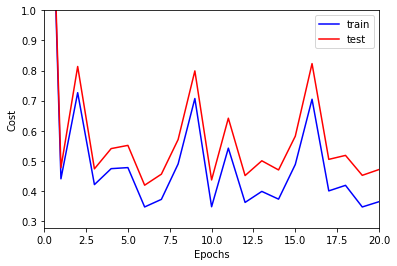

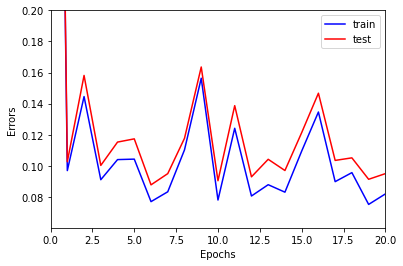

Train/test error after epoch 20: 0.081946, 0.095000


In [22]:
W,b = initialize_params(28*28, 10)

### START YOUR CODE ### 
params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=20, alpha=0.2, batchsize=64, debug=False)
metrics.plot_cost_curves(ymin=0.0, ymax=1.0,logy=False)
metrics.plot_error_curves(ymin=0.0, ymax=0.2,logy=False)
metrics.print_latest_errors()
### END YOUR CODE ### 

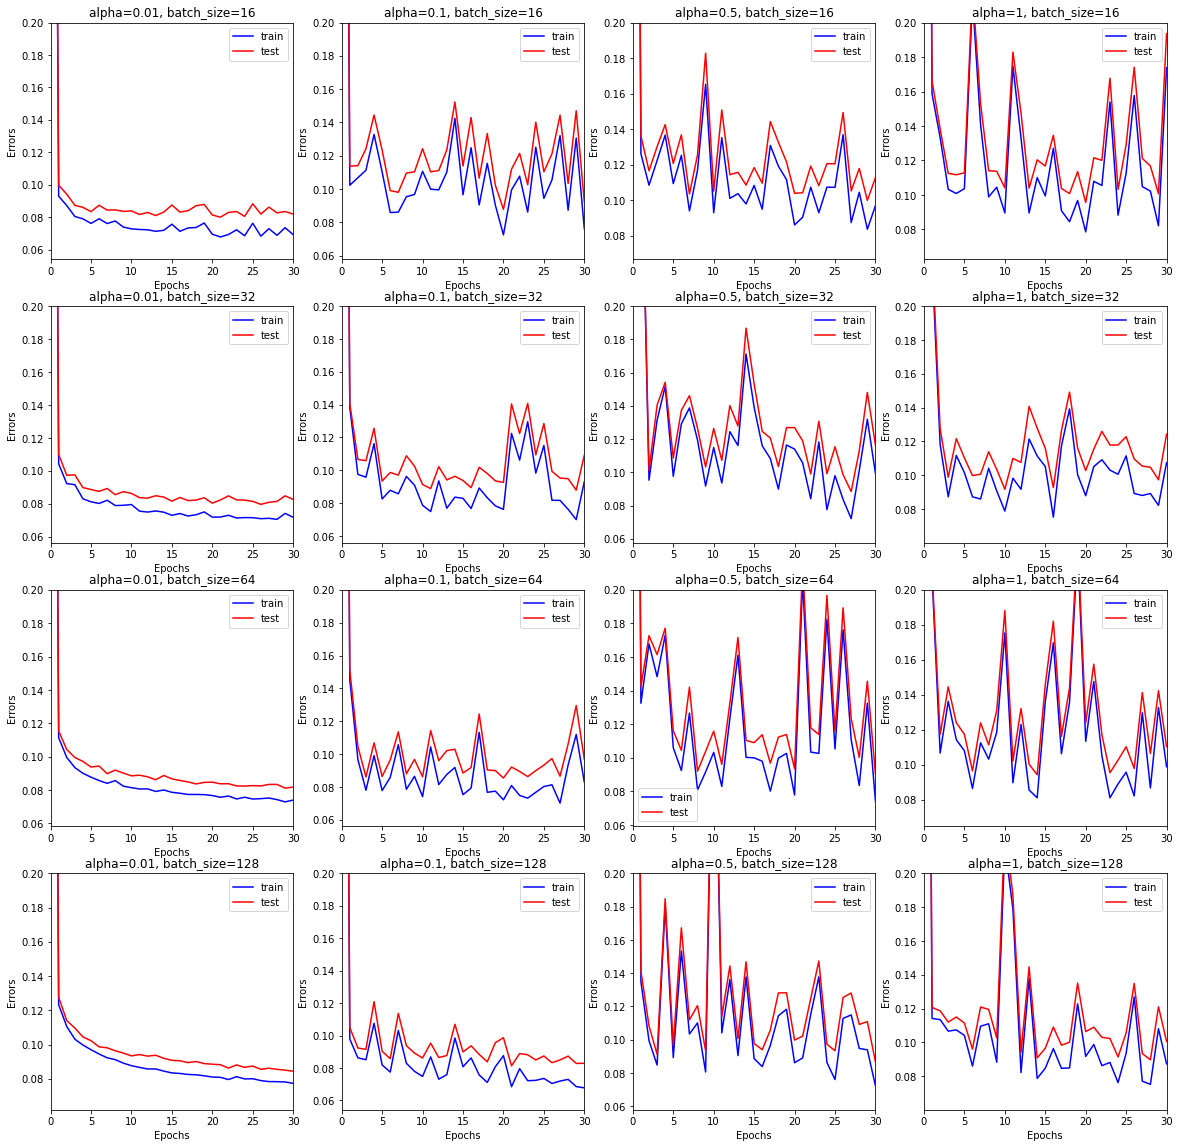

In [23]:
import itertools
from IPython.display import clear_output   

def plot_hyperparam_grid(init_params_method, alphas=[0.01, 0.1, 0.5, 1], batch_sizes=[16, 32, 64, 128], nepochs=30):
    fig, axes = plt.subplots(len(batch_sizes), len(alphas), figsize=(20, 20))

    axes = axes.reshape(-1)

    i = 0
    for batch_size, alpha in itertools.product(batch_sizes, alphas):
        plt.sca(axes[i])
        i += 1

        plt.title(f"alpha={alpha}, batch_size={batch_size}")
        W,b = initialize_params(28*28, 10, method=init_params_method)
        params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha=alpha, batchsize=batch_size, debug=False)
        metrics.plot_error_curves(logy=False, ymin=0.0, ymax=0.2, show=False)

    clear_output()
    plt.show()

plot_hyperparam_grid(init_params_method="zero")

### 1b Explore Hyper-Parameter Settings and Describe your Findings

Now run the training with different settings: 
* Different learning rate
* Different number of epochs
* Different batch size 

Explore which combination is best suited to obtain good test performance. Keep an eye on random estimates for the error rates due to random parameter initialisation and randomly shuffled mini-batches. 

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 5: 1.105007, 1.339693
Train/test error after epoch 5: 0.083893, 0.097143


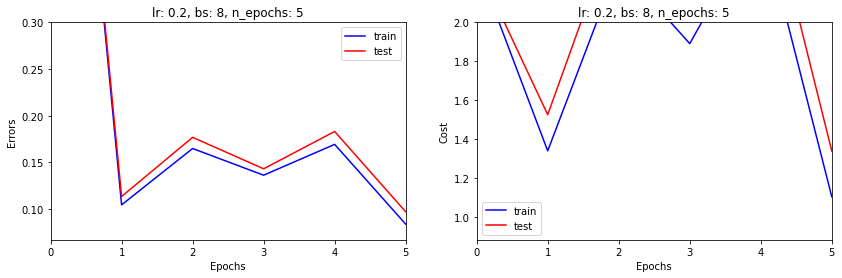

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 20: 1.205234, 1.567506
Train/test error after epoch 20: 0.089143, 0.105429


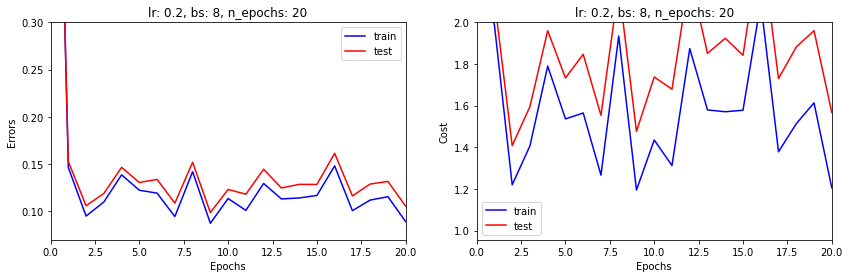

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 40: 1.158151, 1.595124
Train/test error after epoch 40: 0.088089, 0.107929


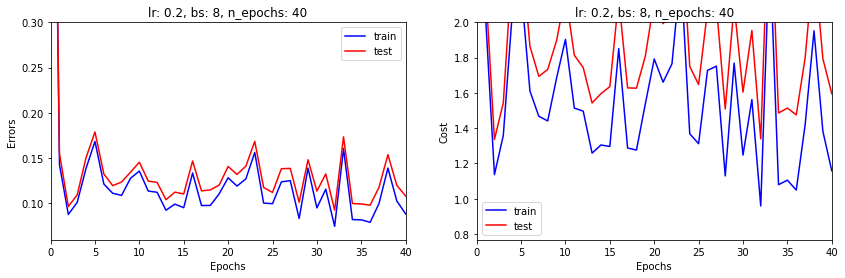

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 5: 0.764578, 0.921466
Train/test error after epoch 5: 0.087946, 0.098500


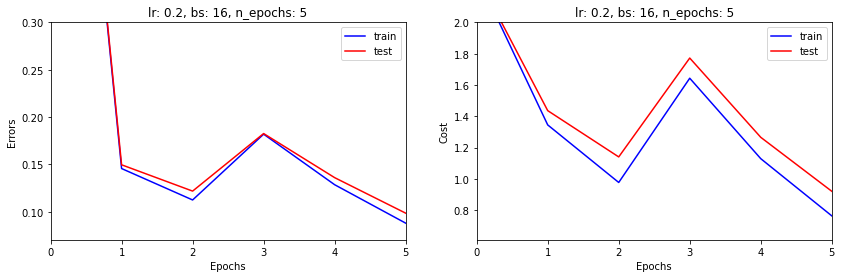

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 20: 0.671834, 0.917670
Train/test error after epoch 20: 0.077446, 0.091357


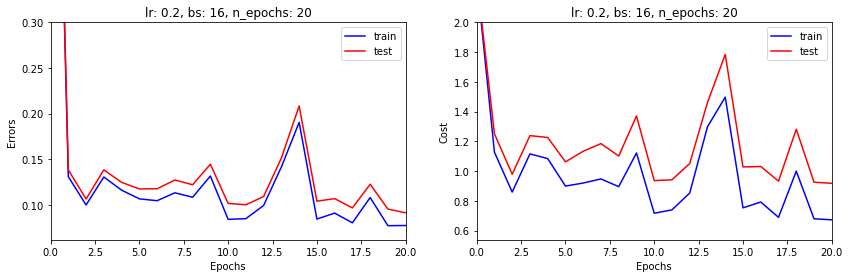

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 40: 0.953355, 1.292577
Train/test error after epoch 40: 0.110125, 0.129357


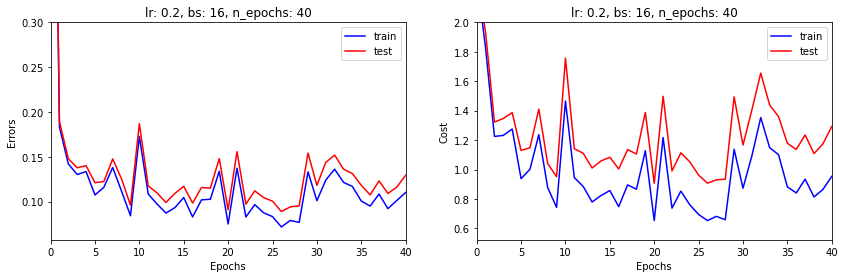

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 5: 0.868875, 1.000117
Train/test error after epoch 5: 0.154625, 0.168143


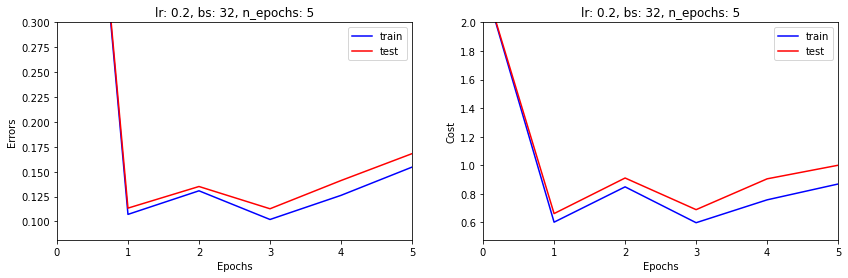

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 20: 0.659443, 0.825312
Train/test error after epoch 20: 0.117732, 0.127357


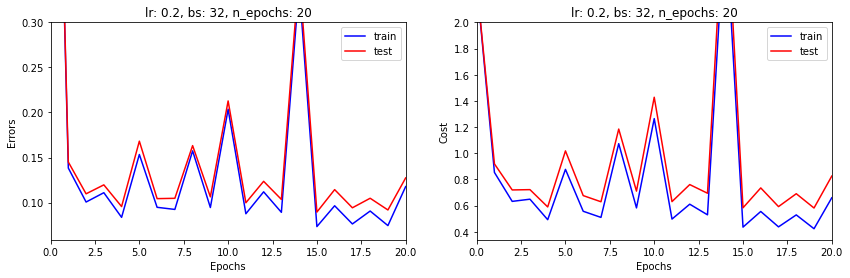

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 40: 0.513243, 0.718830
Train/test error after epoch 40: 0.089875, 0.107571


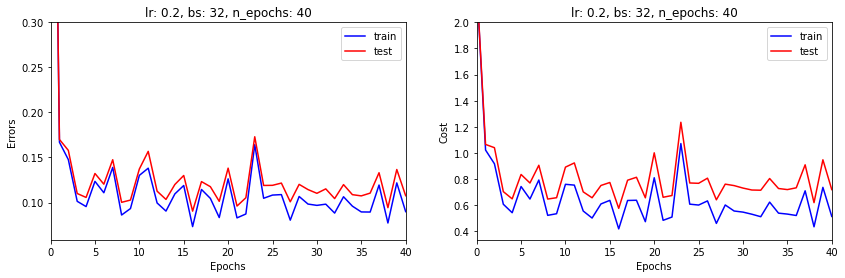

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 5: 0.638486, 0.702539
Train/test error after epoch 5: 0.138000, 0.147857


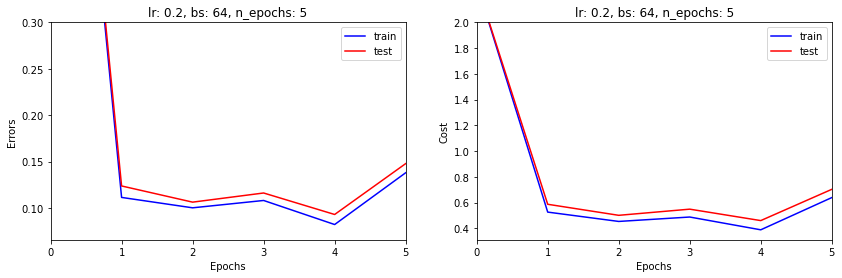

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.477449, 0.588675
Train/test error after epoch 20: 0.106821, 0.121286


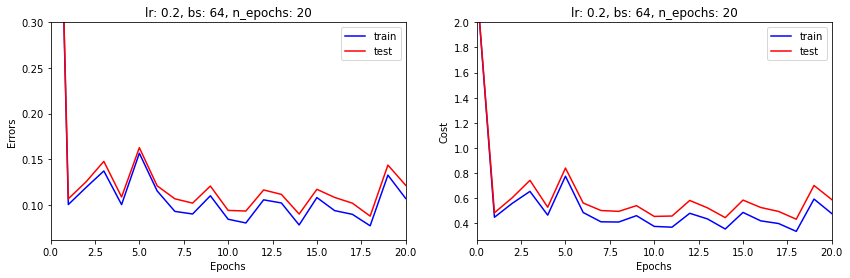

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 40: 0.376353, 0.511512
Train/test error after epoch 40: 0.084554, 0.101500


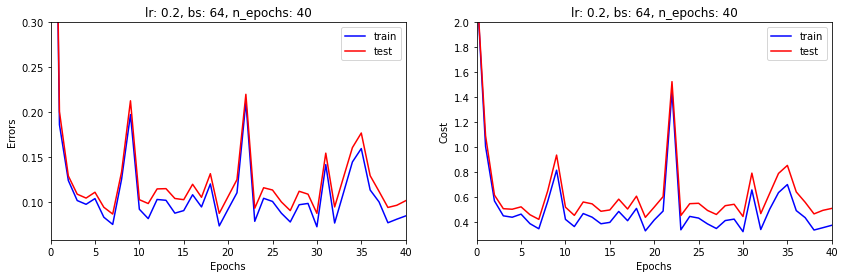

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 5: 0.498363, 0.557649
Train/test error after epoch 5: 0.125714, 0.135357


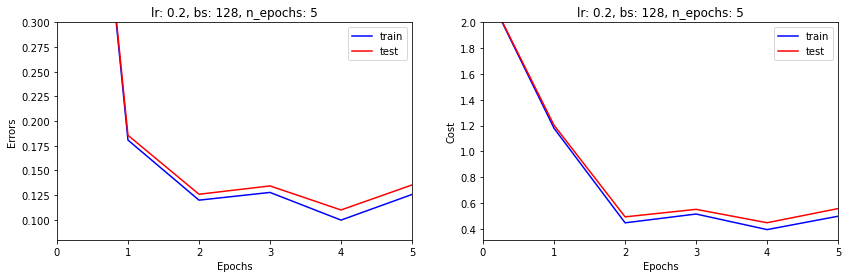

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 20: 0.405074, 0.492438
Train/test error after epoch 20: 0.106161, 0.122714


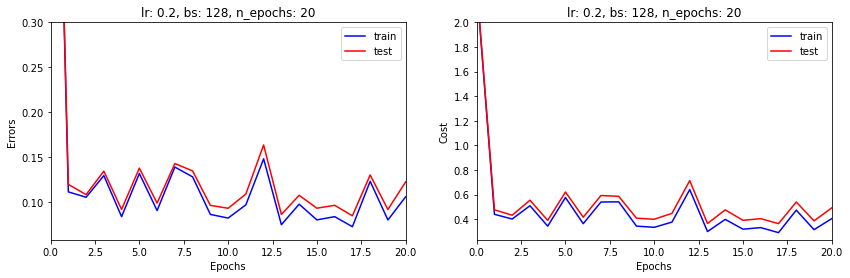

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 40: 0.313105, 0.402434
Train/test error after epoch 40: 0.079250, 0.094857


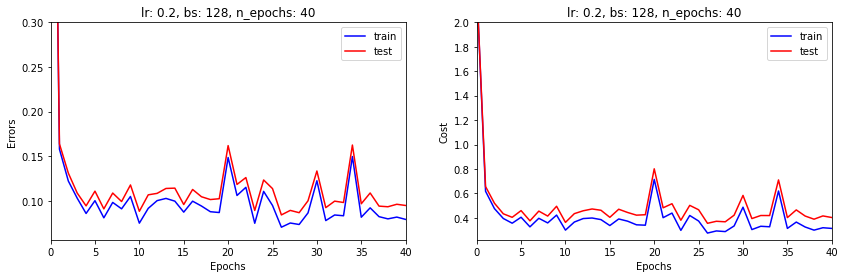

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 5: 0.288275, 0.334371
Train/test error after epoch 5: 0.079946, 0.089786


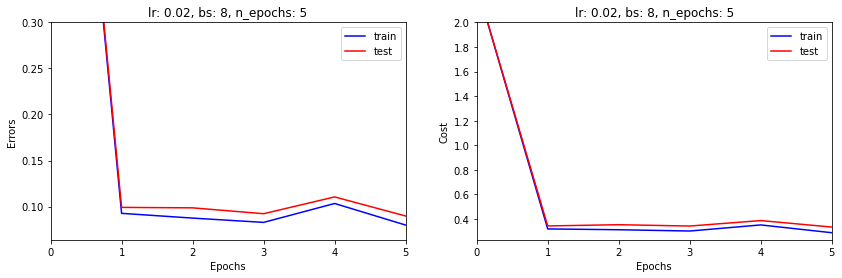

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 20: 0.255467, 0.328071
Train/test error after epoch 20: 0.069679, 0.085929


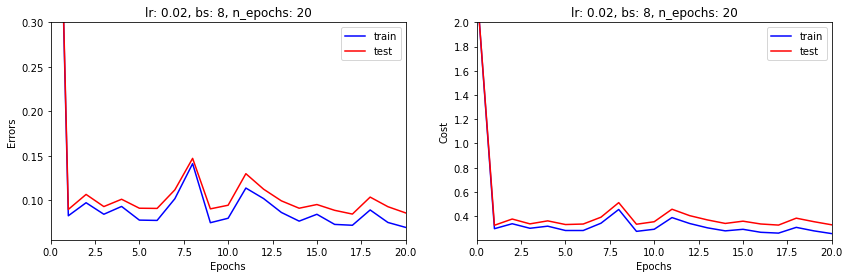

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 40: 0.283673, 0.376758
Train/test error after epoch 40: 0.082536, 0.097500


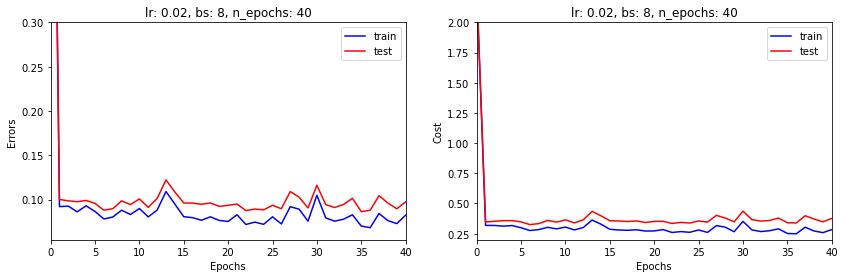

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 5: 0.285215, 0.323873
Train/test error after epoch 5: 0.079411, 0.090143


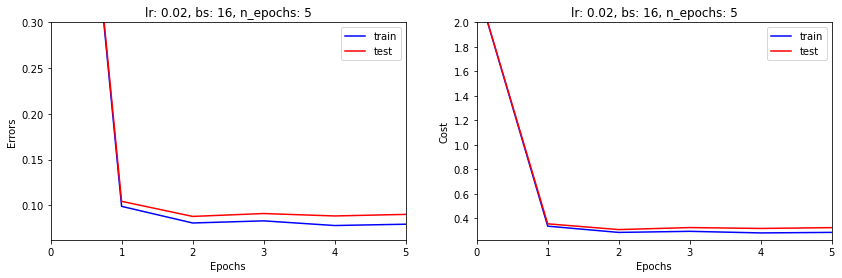

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 20: 0.257122, 0.312443
Train/test error after epoch 20: 0.073268, 0.085929


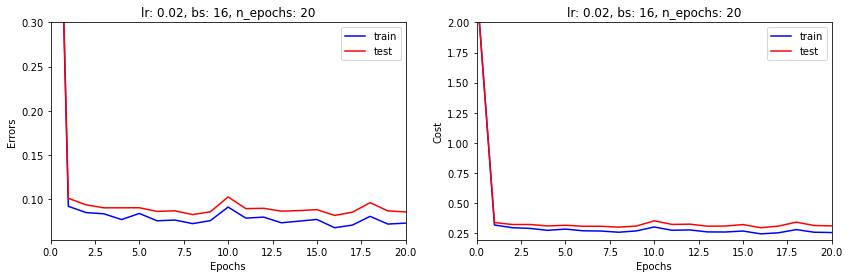

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 40: 0.248655, 0.315595
Train/test error after epoch 40: 0.071518, 0.086929


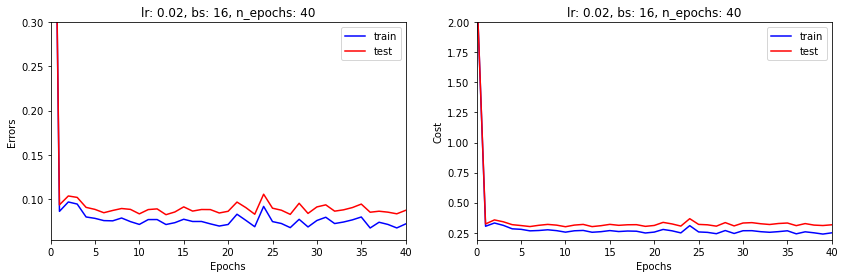

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 5: 0.288533, 0.314512
Train/test error after epoch 5: 0.080893, 0.088857


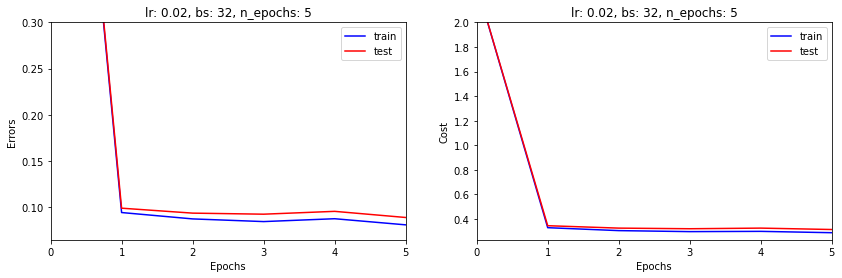

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 20: 0.253869, 0.297917
Train/test error after epoch 20: 0.070839, 0.082286


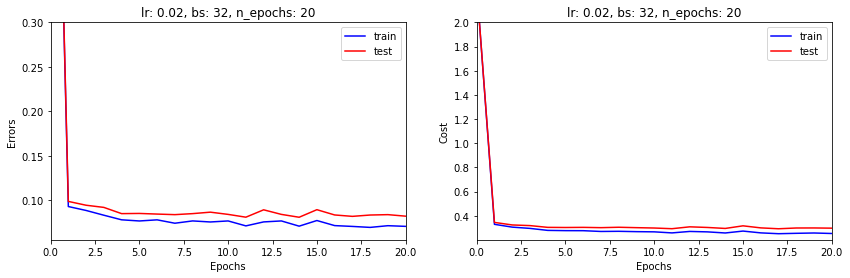

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 40: 0.241635, 0.293326
Train/test error after epoch 40: 0.066661, 0.080071


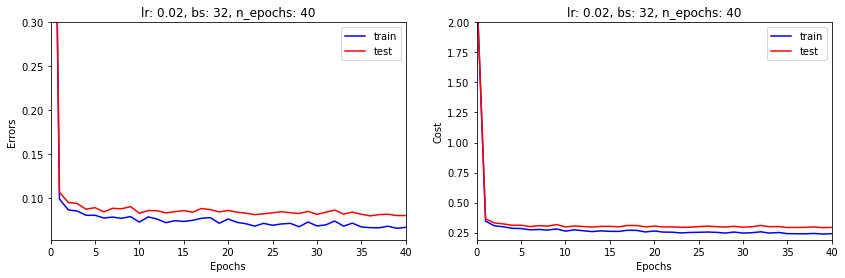

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 5: 0.292697, 0.314139
Train/test error after epoch 5: 0.082482, 0.089500


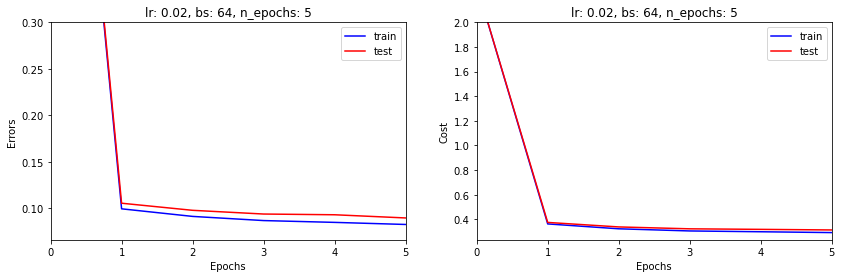

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.261435, 0.295267
Train/test error after epoch 20: 0.072518, 0.083357


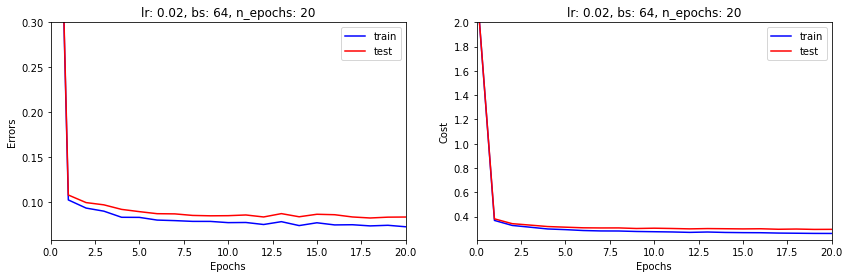

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 40: 0.251736, 0.296448
Train/test error after epoch 40: 0.070661, 0.082429


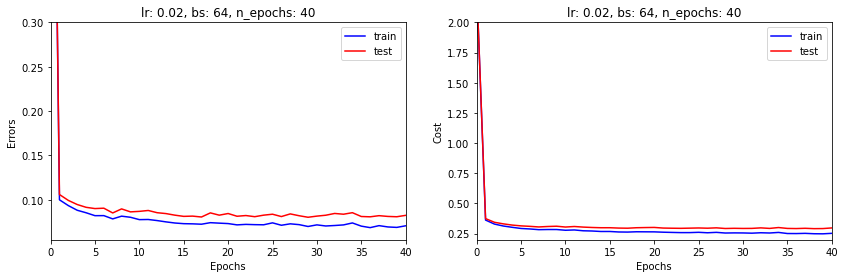

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 5: 0.315498, 0.330742
Train/test error after epoch 5: 0.089893, 0.095429


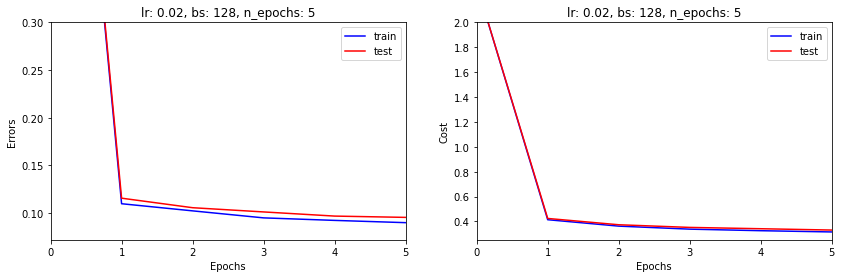

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 20: 0.273633, 0.301192
Train/test error after epoch 20: 0.076839, 0.084500


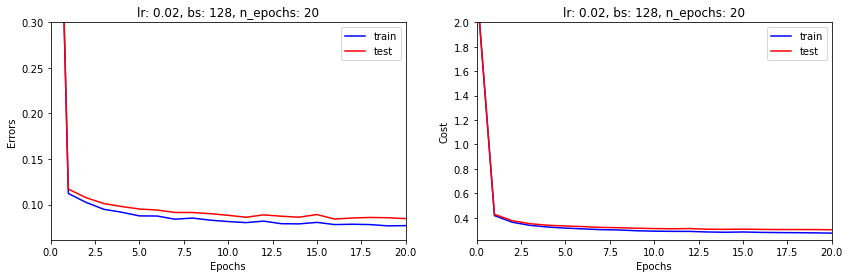

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 40: 0.257827, 0.291643
Train/test error after epoch 40: 0.072214, 0.082000


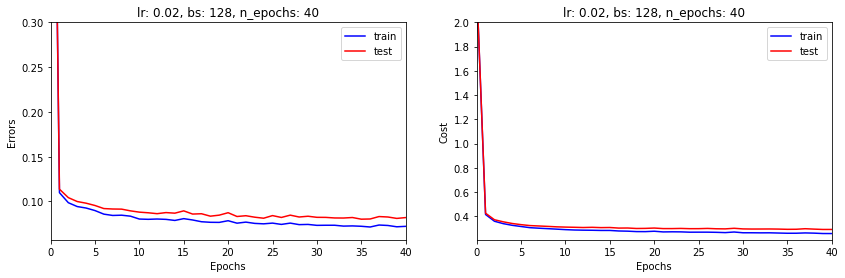

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 5: 0.300939, 0.320633
Train/test error after epoch 5: 0.085054, 0.092214


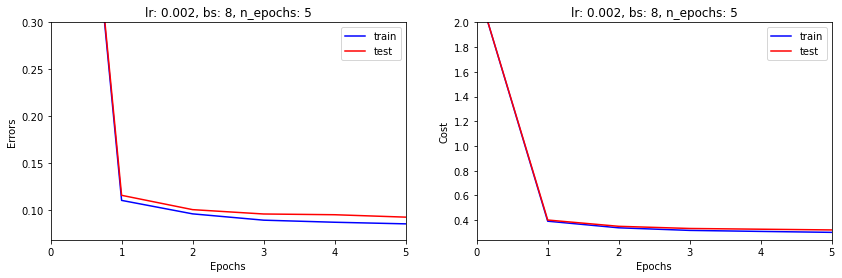

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 20: 0.268263, 0.301122
Train/test error after epoch 20: 0.075107, 0.083500


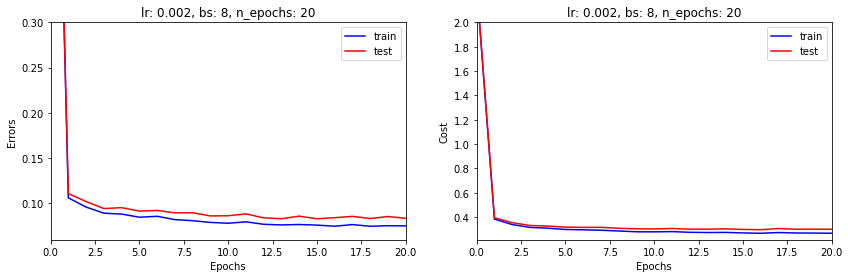

Optimisation with batchsize 8 and 7000 number of batches per epoch.
Train/test cost after epoch 40: 0.251845, 0.290344
Train/test error after epoch 40: 0.069446, 0.079929


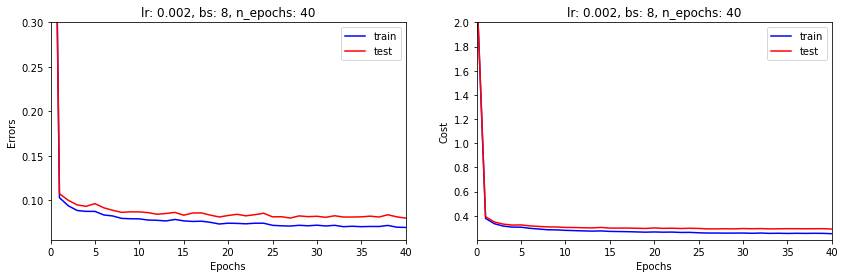

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 5: 0.324174, 0.338849
Train/test error after epoch 5: 0.091911, 0.097429


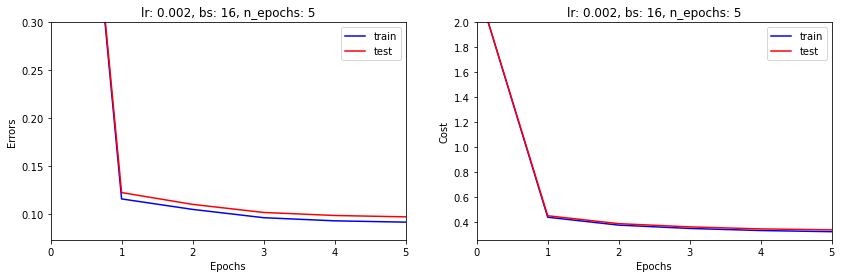

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 20: 0.279386, 0.304329
Train/test error after epoch 20: 0.077518, 0.085071


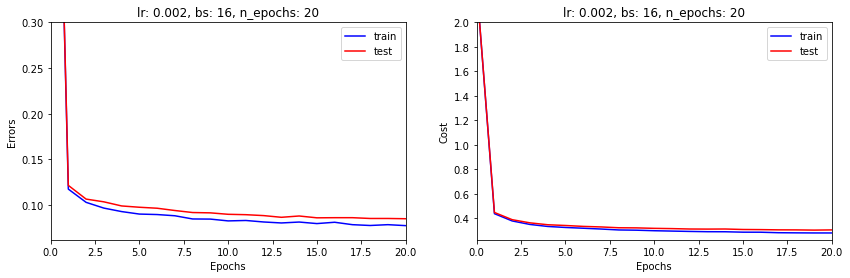

Optimisation with batchsize 16 and 3500 number of batches per epoch.
Train/test cost after epoch 40: 0.262946, 0.294973
Train/test error after epoch 40: 0.072643, 0.081357


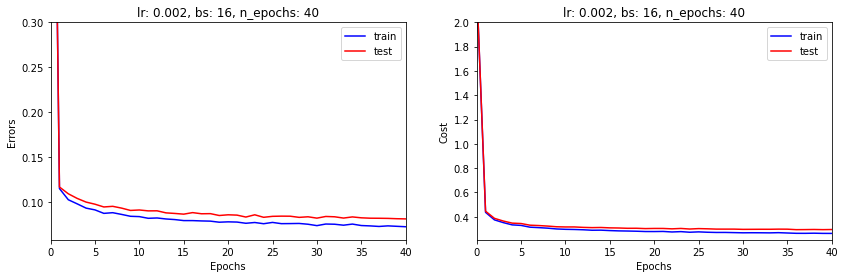

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 5: 0.359184, 0.371450
Train/test error after epoch 5: 0.099071, 0.104929


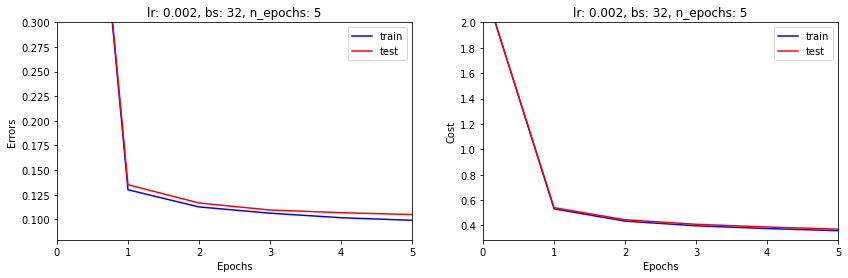

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 20: 0.296788, 0.316106
Train/test error after epoch 20: 0.083446, 0.090571


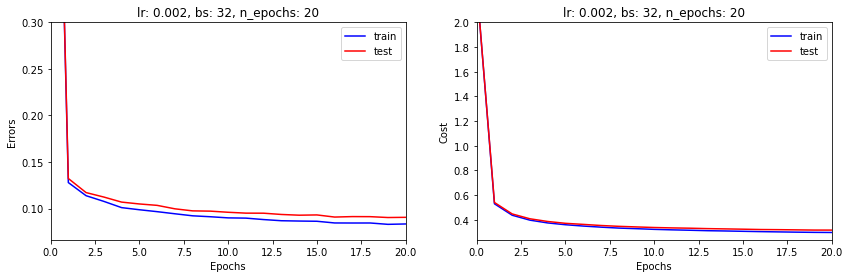

Optimisation with batchsize 32 and 1750 number of batches per epoch.
Train/test cost after epoch 40: 0.276628, 0.301291
Train/test error after epoch 40: 0.077571, 0.084571


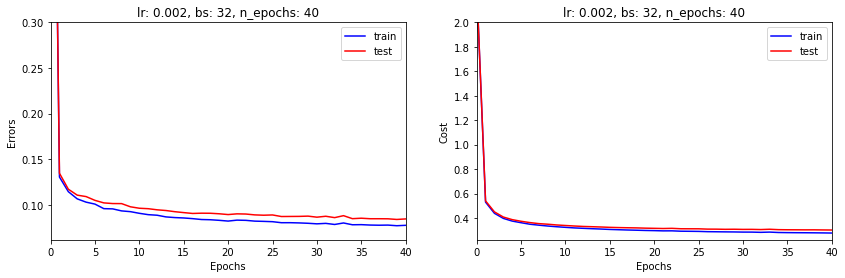

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 5: 0.412463, 0.423290
Train/test error after epoch 5: 0.108857, 0.113000


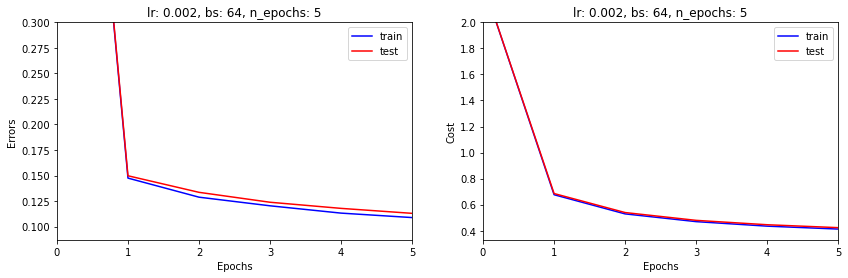

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 20: 0.322702, 0.337227
Train/test error after epoch 20: 0.090911, 0.096500


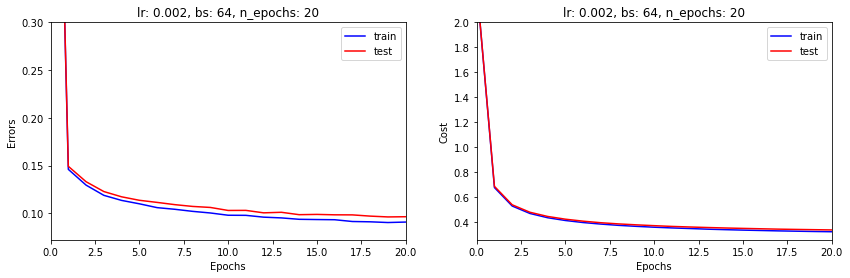

Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 40: 0.295880, 0.315357
Train/test error after epoch 40: 0.082946, 0.090143


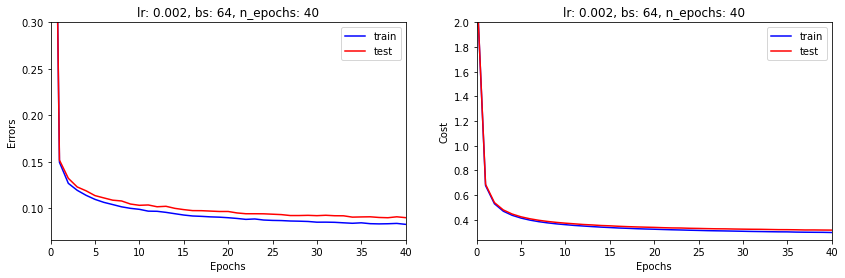

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 5: 0.493545, 0.503178
Train/test error after epoch 5: 0.122875, 0.126929


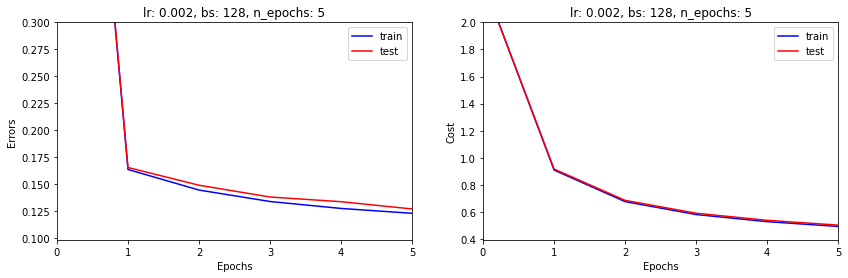

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 20: 0.358915, 0.370964
Train/test error after epoch 20: 0.098661, 0.104429


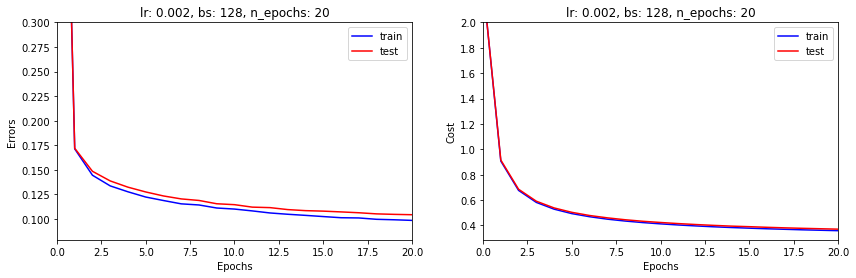

Optimisation with batchsize 128 and 437 number of batches per epoch.
Train/test cost after epoch 40: 0.322018, 0.337128
Train/test error after epoch 40: 0.089821, 0.095357


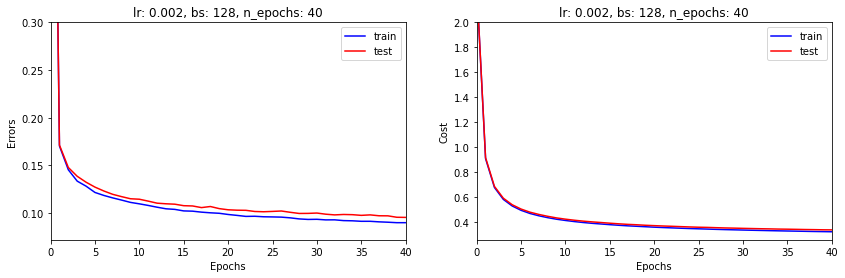

In [24]:
import itertools

lr = [0.2, 0.02, 0.002]
bs = [8, 16, 32, 64, 128]
epochs = [5, 20, 40]

for learning_rate, batch_size, n_epochs in itertools.product(lr, bs, epochs):
    # train the model
    W,b = initialize_params(28*28, 10)
    params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, 
                           nepochs=n_epochs, alpha=learning_rate, batchsize=batch_size, 
                           debug=False)
    
    # plot the figures
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title('lr: {0}, bs: {1}, n_epochs: {2}'.format(learning_rate, batch_size, n_epochs))
    metrics.plot_error_curves(ymin=0.0, ymax=0.3, logy=False, show=False)
    
    plt.subplot(1, 2, 2)
    plt.title('lr: {0}, bs: {1}, n_epochs: {2}'.format(learning_rate, batch_size, n_epochs))
    metrics.plot_cost_curves(ymin=0.0, ymax=2.0, logy=False, show=False)
    
    plt.show()

#### YOUR FINDINGS ...

A learning rate of `0.01` with `64` batch size and `30` epochs seemed to get the best results. Those parameters are reasonable because we can observe a nice convergence but also some stochasicity due to the mini-batch procedure which means that the model will be able to escape sharp narrow minima durring the optimization process. As the cost function also shows convergence, no more epochs are required.


Optimisation with batchsize 64 and 875 number of batches per epoch.
Train/test cost after epoch 30: 0.264770, 0.295724
Train/test error after epoch 30: 0.074339, 0.084071


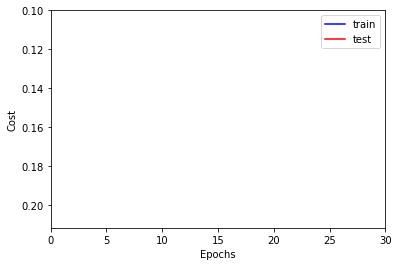

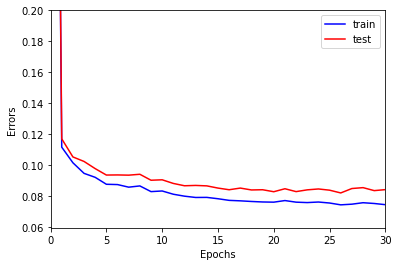

In [27]:
W,b = initialize_params(28*28, 10)

params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=30, alpha=0.01, batchsize=64, debug=False)
metrics.plot_cost_curves(logy=False, ymin=0.0, ymax=0.1)
metrics.plot_error_curves(logy=False, ymin=0.0, ymax=0.2)

### 1c Compute the Error Rates for the individual Digits

Now compute and print (or plot) the rate of misclassified images per digit (i.e. How many digits with label k are not been classified as label k).

Which one seems most difficult to classify?

Plot a few images of the wrongly classified images that have the label of the class that is most difficult to classify.  

In [28]:
W = params['W']
b = params['b']
y_pred = predict(W,b,x_test)

### START YOUR CODE ### 
for d in range(10):
    x_test_d = x_test[:, (y_test == d).reshape(-1)]
    y_pred_d = y_pred[:, (y_test == d).reshape(-1)]
    
    misclassified = (np.argmax(y_pred_d, axis=0) != d).sum()
    errors = misclassified / y_pred_d.shape[1]
    print(f"Digit {d}: {errors}% ({misclassified} of {y_pred_d.shape[1]} samples)")

misclassified = (np.argmax(y_pred, axis=0) != y_test).sum()
errors = misclassified / y_pred.shape[1]
print(f"Total: {errors}% ({misclassified} of {y_pred.shape[1]} samples)")
    
### END YOUR CODE ### 

Digit 0: 0.03840579710144928% (53 of 1380 samples)
Digit 1: 0.028186274509803922% (46 of 1632 samples)
Digit 2: 0.09002093510118632% (129 of 1433 samples)
Digit 3: 0.1376659678546471% (197 of 1431 samples)
Digit 4: 0.07981927710843373% (106 of 1328 samples)
Digit 5: 0.12490362374710871% (162 of 1297 samples)
Digit 6: 0.056348610067618335% (75 of 1331 samples)
Digit 7: 0.060941828254847646% (88 of 1444 samples)
Digit 8: 0.13397483345669875% (181 of 1351 samples)
Digit 9: 0.10196649672250546% (140 of 1373 samples)
Total: 0.08407142857142857% (1177 of 14000 samples)


The digit `8` seems to be the hardest one

__Plot some misclassified of the most difficult class:__

<ipython-input-4-b7644e9398ea>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, index+1)


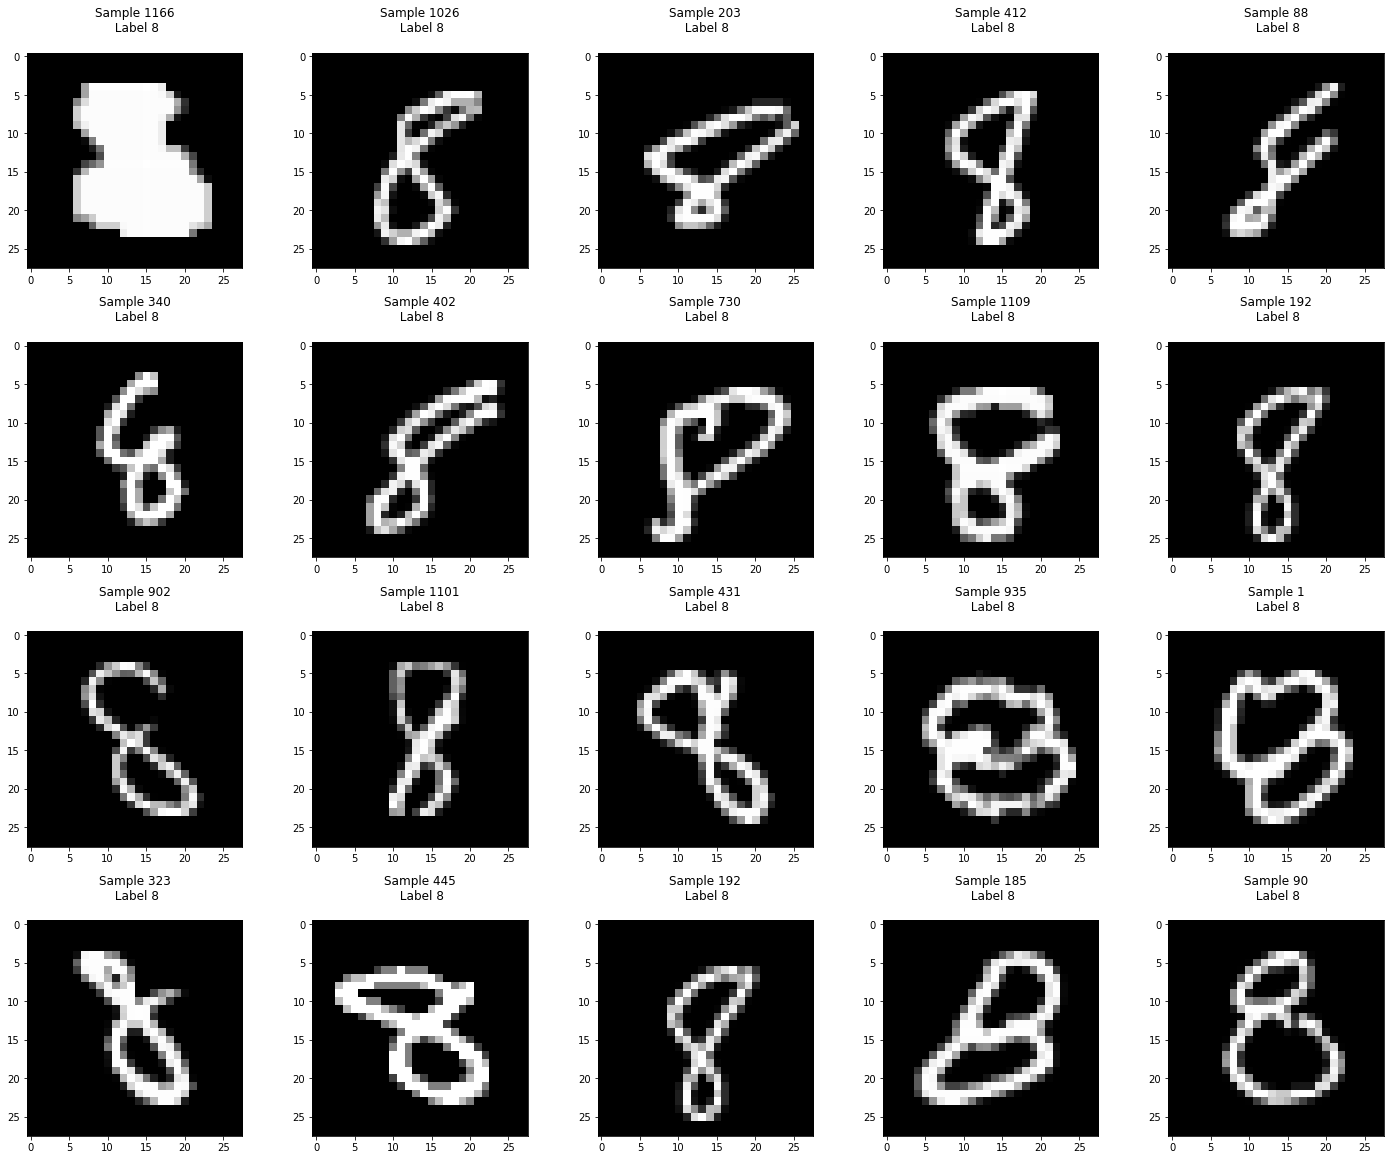

In [29]:
### START YOUR CODE ### 
d = 8
x_test_d = x_test[:, (y_test == d).reshape(-1)]
y_pred_d = y_pred[:, (y_test == d).reshape(-1)]
y_test_d = y_test[:, (y_test == d).reshape(-1)]
    
false_classified_indices = np.argwhere((np.argmax(y_pred_d, axis=0) != y_test_d).reshape(-1)).reshape(-1)
idx = np.random.choice(false_classified_indices, size=20)
plot_digits(x_test_d,y_test_d, idx, shape, cols=5)
### END YOUR CODE ### 

### 1d Analyse Wrongly Classified Images

For the given best choice of hyper-parameters explore the mis-classified images.
Select the images the model was wrong and most uncertain with and characterize which digits were most often confused and why.
For plotting and inspecting, you can use the `plot_digits`-function defined above. 

<ipython-input-4-b7644e9398ea>:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows, cols, index+1)


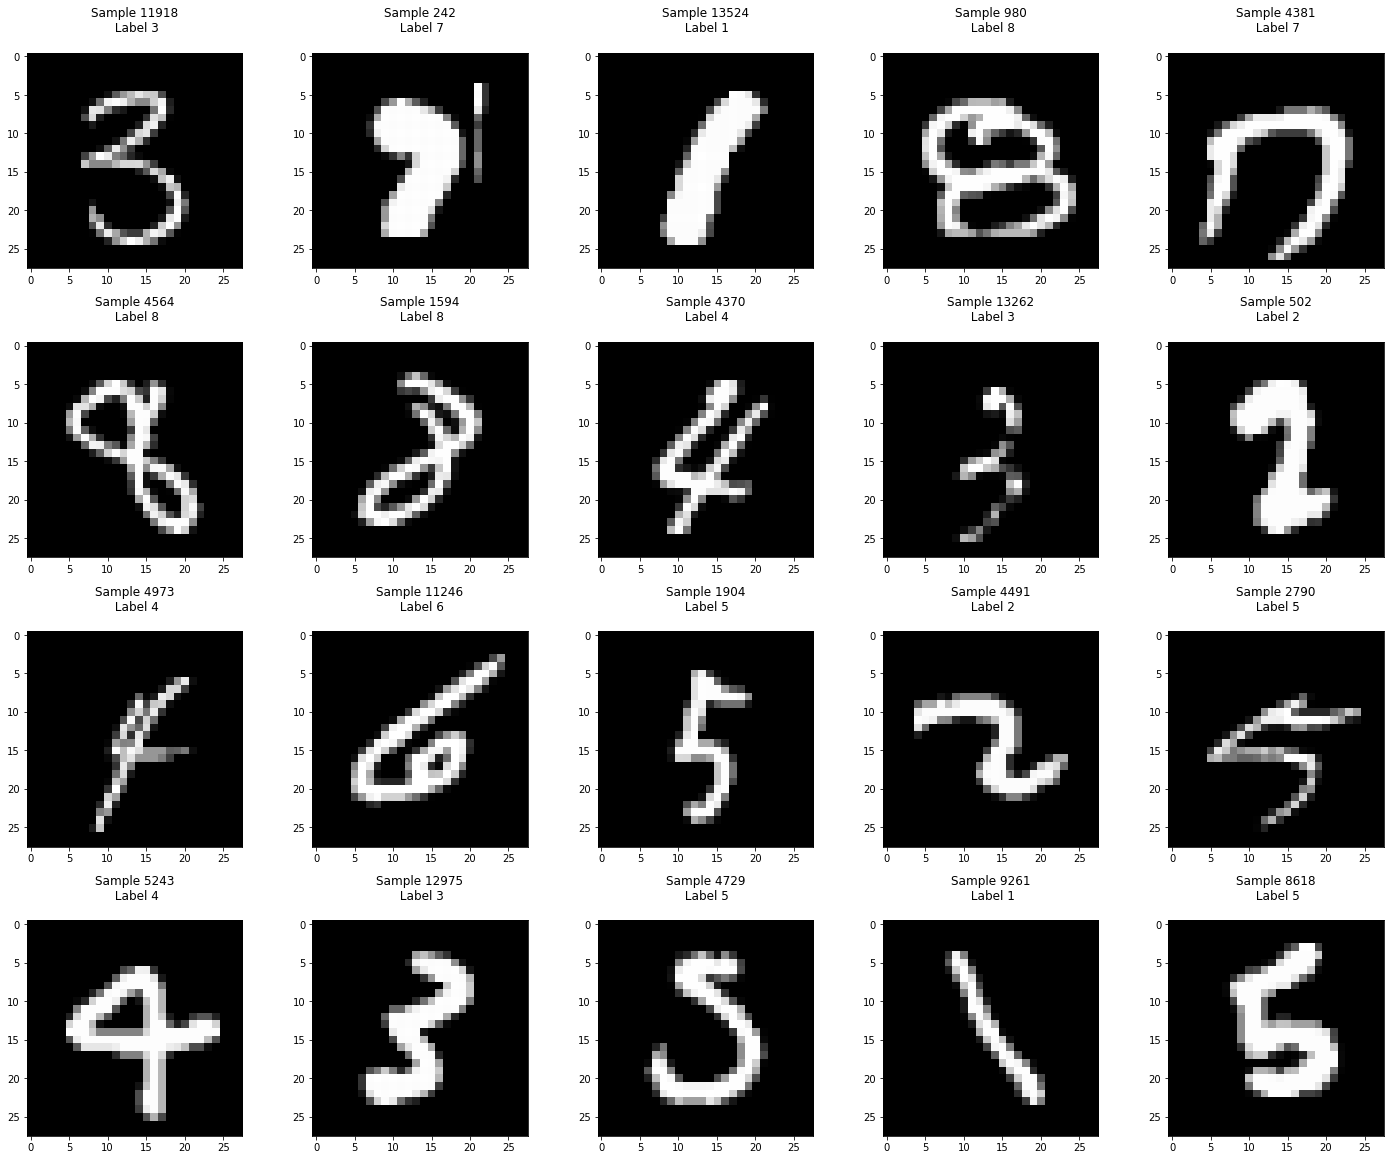

In [30]:
### START YOUR CODE ### 

false_classified_indices = np.argwhere((np.argmax(y_pred, axis=0) != y_test).reshape(-1)).reshape(-1)
idx = np.random.choice(false_classified_indices, size=20)
plot_digits(x_test,y_test, idx, shape, cols=5)
### END YOUR CODE ### 

Most of the misclassified digits seem to exhibit some kind of bad handwriting.

### Plot the Trained Weights as Image 

The following cell allows you to plot the trained weights as images and the trained bias for the 10 digits. This helps to understand what the given model actually is doing. For larger (deeper) models, this won't be that easy any more. 

__QUESTION:__ 
* What could you tell about the predictions made by the model if one of the bias terms would be much larger than all the others (e.g. $b_5=10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

  - <font style="color:red">That would mean the model thinks that such a digit is generally more likely to be seen in a image, which would indicate an inbalance in the used training data.</font>

* What could you tell about the predictions made by the model if one of the bias terms would be much smaller than all the others (e.g. $b_5=-10$ while $b_k\in[-0.1,0.1]$ for $k\ne5$)?

  -  <font style="color:red">That would mean the model thinks that such a digit is generally less likely to be seen in a image, which would indicate an inbalance in the used training data.</font>

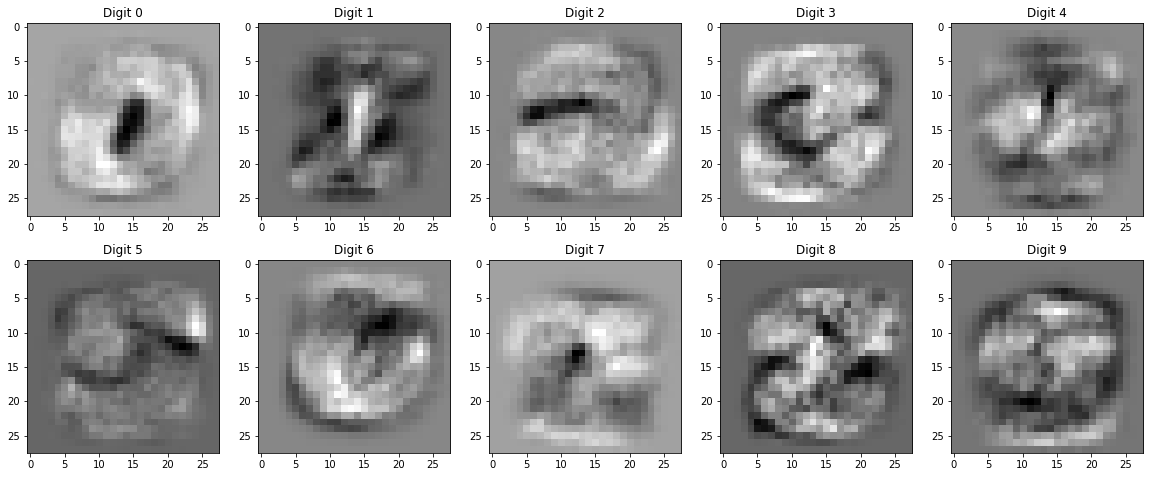

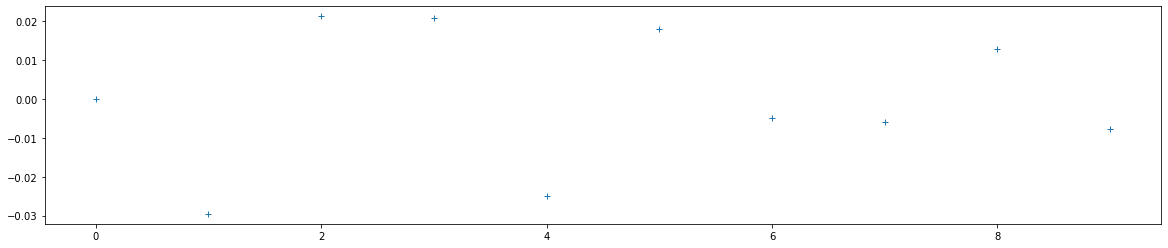

In [31]:
weights = params['W']
biases = params['b']
cols = 5
rows = 2
plt.figure(figsize=(20,4*rows))
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.reshape(weights[i], (28,28)), cmap=plt.cm.gray)
    plt.title('Digit %i'%i, fontsize = 12)

plt.figure(figsize=(20,4))
plt.plot(range(10), [biases[i] for i in range(10)], '+')

### 1f Analyse Weights Initialisation 

Implement and compare the weights initialisation strategies 1.-3.

__QUESTION:__ Are there significant differences in the learning, the hyper parameter settings needed, the resulting error rates (and misclassified digits) for the different initialisation strategies? 

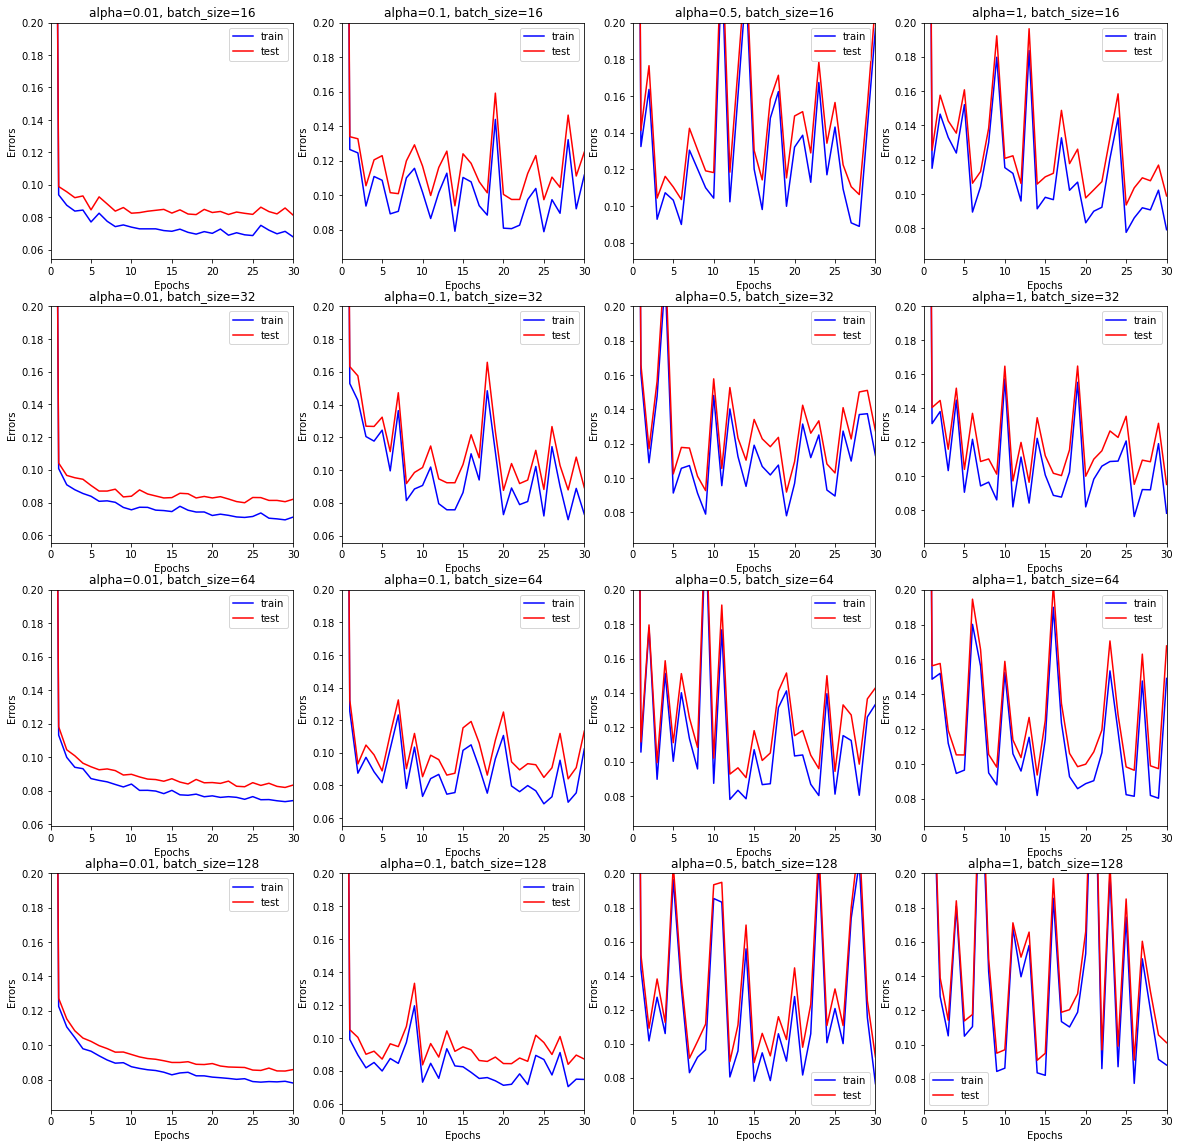

In [32]:
plot_hyperparam_grid(init_params_method="zero")

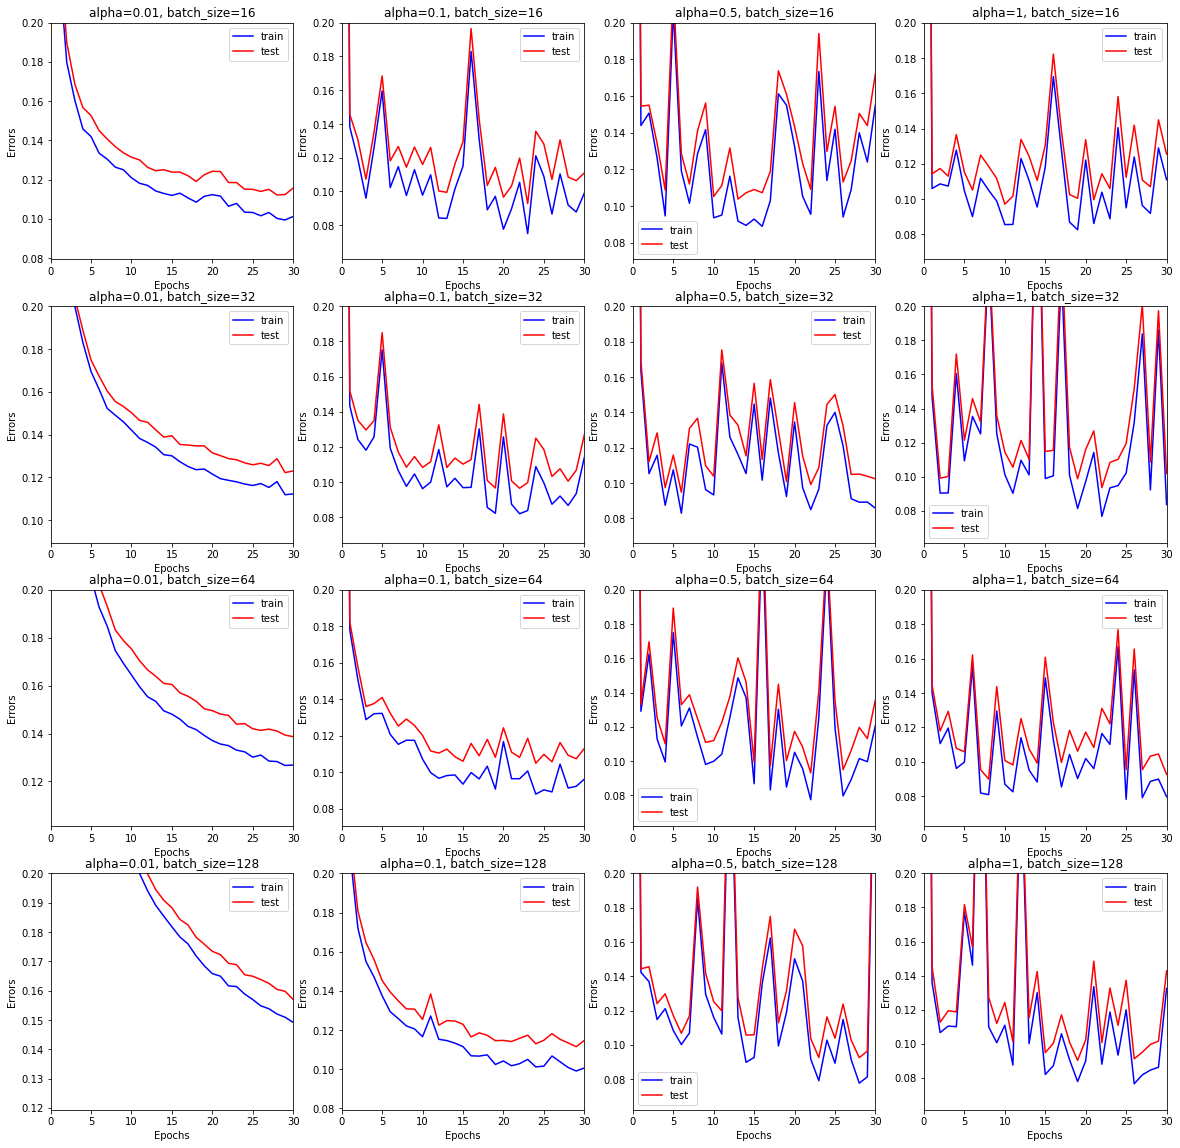

In [33]:
plot_hyperparam_grid(init_params_method="standard_normal")

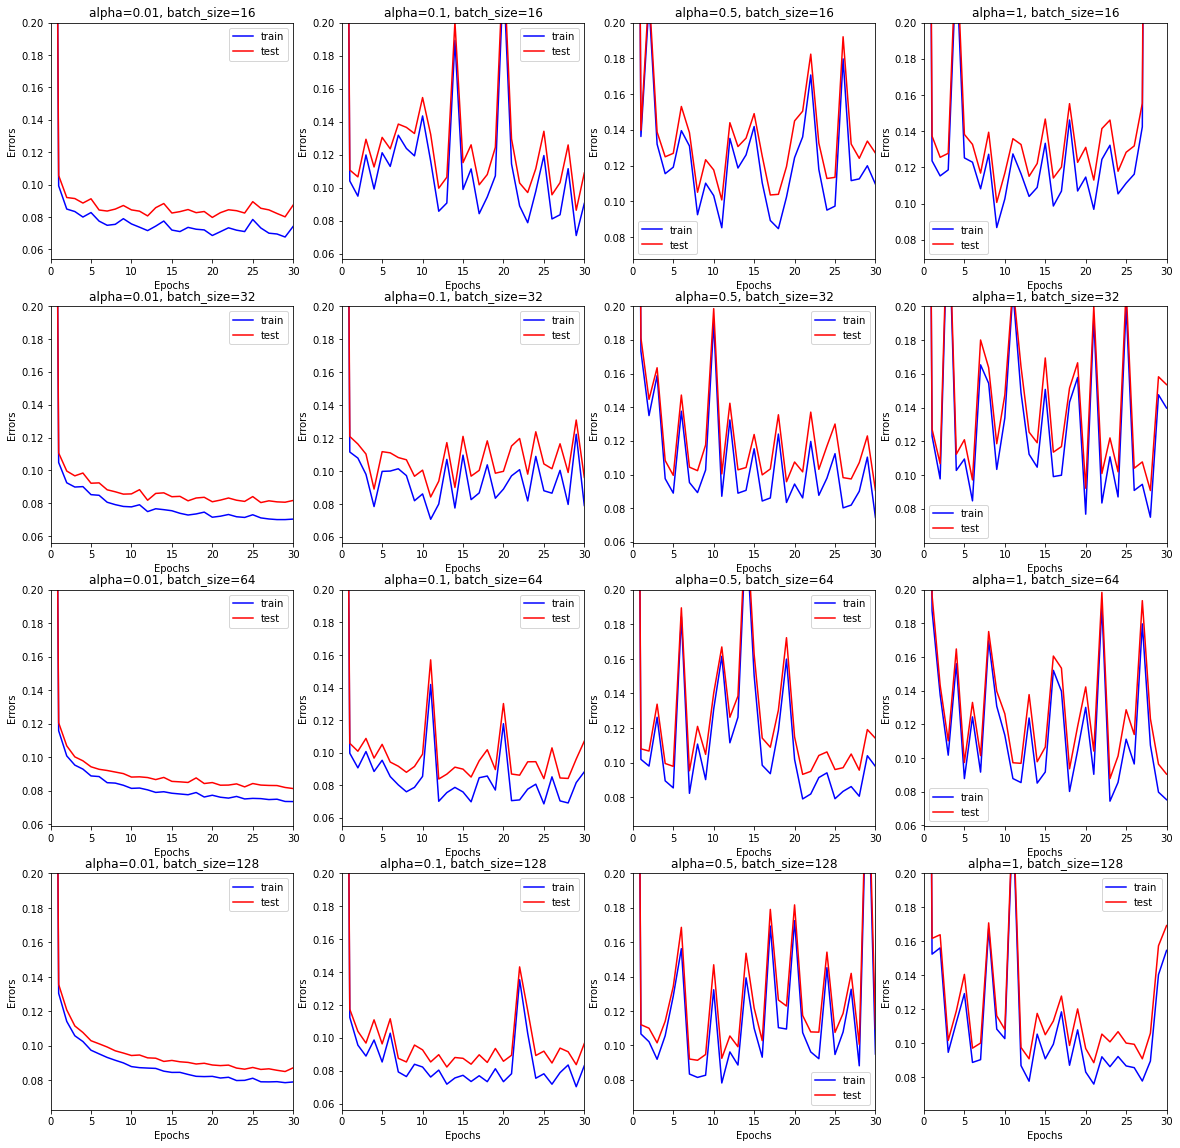

In [34]:
plot_hyperparam_grid(init_params_method="scaled_normal")

It seems like using a `standard_normal` initialisation is not as well suited for the MNIST problem as it is the case for `0` weights. The optimization process shows faster convergence using the later one. The `scaled_normal` initialisation seems to perform rather similar to `0` weights. This is most probably due to the scaling term, which is in the MNIST case $784^{-1/2}=28^{-1}$ hence the weights will be sampled from $\sim\mathcal N(0, 28^{-1})$. As samples from that distribution will be very close to `0`, it is reasonable that such a initialization technique performs similar to simple `0` weights. <br>
The reason that `0` weights initialisation performs better than `standard_normal` could be that the most of the pixels in the input image are not very relevant to detect the digit. Hence their optimal weight is very close to `0`. Note that in the weights plot we created above, most of the pixels are gray which indicates not very positive nor very negative values.